Link to origin paper:https://ieeexplore.ieee.org/document/8470101

In [9]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from PIL import Image
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import math
import os
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

# Load Data

## Single Folder

In [2]:
def LoadData(path_to_train, path_to_test, classes=None, num_workers=2, batch_size=32, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [3]:
train_loader, valid_loader,test_loader, classes = LoadData(path_to_train='/projectnb/dl523/projects/GAN_Detector/progan_train/horse/',path_to_test='/projectnb/dl523/projects/GAN_Detector/CNN_synth_testset/progan/horse/',
                                                                       classes=['Real','Fake'],num_workers=2, batch_size=16, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


## Whole Dataset

In [12]:
valid_size = .05
batch_size = 16
num_workers = 2
classes = ["Real", "Fake"]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

test_transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

categories = os.listdir("/projectnb/dl523/projects/GAN_Detector/progan_train")
train_datasets = []
print("Loading Training Data...", flush=True)
for category in tqdm(categories):
    train_datasets.append(datasets.ImageFolder("/projectnb/dl523/projects/GAN_Detector/progan_train/" + category, transform=train_transform))
    
train_dataset = torch.utils.data.ConcatDataset(train_datasets)


#train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)

print("Loading Testing Data...", flush=True)
test_datasets = []
for category in tqdm(categories):
    test_datasets.append(datasets.ImageFolder("/projectnb/dl523/projects/GAN_Detector/CNN_synth_testset/progan/" + category, transform=test_transform))
    
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

class_names = train_datasets[0].classes


Loading Training Data...


100%|██████████| 20/20 [00:02<00:00,  8.88it/s]

Loading Testing Data...



100%|██████████| 20/20 [00:00<00:00, 225.13it/s]


## Load Single test dataset

In [38]:
valid_size = .05
batch_size = 16
num_workers = 2
classes = ["Real", "Fake"]

test_transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

# option 1 for cyclegan, progan, stylegan, stylegan2
# categories = os.listdir("/projectnb/dl523/projects/GAN_Detector/CNN_synth_testset/stylegan2")
# test_datasets = []
# for category in tqdm(categories):
#     test_datasets.append(datasets.ImageFolder("/projectnb/dl523/projects/GAN_Detector/CNN_synth_testset/stylegan2/" + category, transform=test_transform))
# test_dataset = torch.utils.data.ConcatDataset(test_datasets)

# option 2 for biggan,crn,deepfake,gaugan,imle,san,seeingdark,stargan,whichfaceisreal
path_to_test = "/projectnb/dl523/projects/GAN_Detector/CNN_synth_testset/whichfaceisreal/"
test_dataset = datasets.ImageFolder(path_to_test, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

## Data Visualization

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(16, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


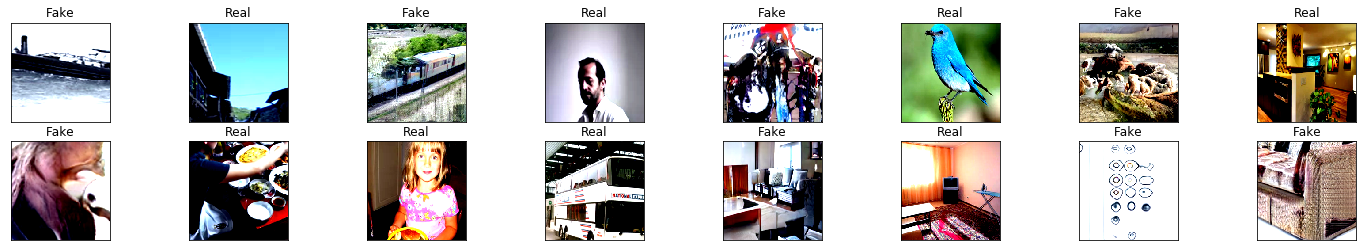

In [19]:

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [4]:

for a,b in train_loader:
    print(b.size())
    break

torch.Size([32])


# Model

In [16]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [3]:
# code implementation from https://github.com/brijeshiitg/Pytorch-implementation-of-SRNet, 
# which is the implementation of paper "Deep Residual Network for Steganalysis of Digital Images"

class Srnet(nn.Module):
    def __init__(self):
        super(Srnet, self).__init__()
        # Layer 1
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=64,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Layer 2
        self.layer2 = nn.Conv2d(in_channels=64, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        # Layer 3
        self.layer31 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(16)
        self.layer32 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(16)
        # Layer 4
        self.layer41 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn41 = nn.BatchNorm2d(16)
        self.layer42 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn42 = nn.BatchNorm2d(16)
        # Layer 5
        self.layer51 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn51 = nn.BatchNorm2d(16)
        self.layer52 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn52 = nn.BatchNorm2d(16)
        # Layer 6
        self.layer61 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn61 = nn.BatchNorm2d(16)
        self.layer62 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn62 = nn.BatchNorm2d(16)
        # Layer 7
        self.layer71 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn71 = nn.BatchNorm2d(16)
        self.layer72 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn72 = nn.BatchNorm2d(16)
        # Layer 8
        self.layer81 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=1, stride=2, padding=0, bias=False)
        self.bn81 = nn.BatchNorm2d(16)
        self.layer82 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn82 = nn.BatchNorm2d(16)
        self.layer83 = nn.Conv2d(in_channels=16, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn83 = nn.BatchNorm2d(16)
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        # Layer 9
        self.layer91 = nn.Conv2d(in_channels=16, out_channels=64,
            kernel_size=1, stride=2, padding=0, bias=False)
        self.bn91 = nn.BatchNorm2d(64)
        self.layer92 = nn.Conv2d(in_channels=16, out_channels=64,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn92 = nn.BatchNorm2d(64)
        self.layer93 = nn.Conv2d(in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn93 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        # Layer 10
        self.layer101 = nn.Conv2d(in_channels=64, out_channels=128,
            kernel_size=1, stride=2, padding=0, bias=False)
        self.bn101 = nn.BatchNorm2d(128)
        self.layer102 = nn.Conv2d(in_channels=64, out_channels=128,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn102 = nn.BatchNorm2d(128)
        self.layer103 = nn.Conv2d(in_channels=128, out_channels=128,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn103 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        # Layer 11
        self.layer111 = nn.Conv2d(in_channels=128, out_channels=256,
            kernel_size=1, stride=2, padding=0, bias=False)
        self.bn111 = nn.BatchNorm2d(256)
        self.layer112 = nn.Conv2d(in_channels=128, out_channels=256,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn112 = nn.BatchNorm2d(256)
        self.layer113 = nn.Conv2d(in_channels=256, out_channels=256,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn113 = nn.BatchNorm2d(256)
        self.pool3 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 12
        self.layer121 = nn.Conv2d(in_channels=256, out_channels=512,
            kernel_size=3, stride=2, padding=0, bias=False)
        self.bn121 = nn.BatchNorm2d(512)
        self.layer122 = nn.Conv2d(in_channels=512, out_channels=512,
            kernel_size=3, stride=1, padding=1, bias=False)
        self.bn122 = nn.BatchNorm2d(512)
        # avgp = torch.mean() in forward before fc
        # Fully Connected layer
        self.fc = nn.Linear(512*1*1, 2)

    def forward(self, inputs):
        # Layer 1
        conv = self.layer1(inputs)
        actv = F.relu(self.bn1(conv))
        # Layer 2
        conv = self.layer2(actv)
        actv = F.relu(self.bn2(conv))
        # Layer 3
        conv1 = self.layer31(actv)
        actv1 = F.relu(self.bn31(conv1))
        conv2 = self.layer32(actv1)
        bn = self.bn32(conv2)
        res = torch.add(actv, bn)
        # Layer 4
        conv1 = self.layer41(res)
        actv1 = F.relu(self.bn41(conv1))
        conv2 = self.layer42(actv1)
        bn = self.bn42(conv2)
        res = torch.add(res, bn)
        # Layer 5
        conv1 = self.layer51(res)
        actv1 = F.relu(self.bn51(conv1))
        conv2 = self.layer52(actv1)
        bn = self.bn52(conv2)
        res = torch.add(res, bn)
        # Layer 6
        conv1 = self.layer61(res)
        actv1 = F.relu(self.bn61(conv1))
        conv2 = self.layer62(actv1)
        bn = self.bn62(conv2)
        res = torch.add(res, bn)
        # Layer 7
        conv1 = self.layer71(res)
        actv1 = F.relu(self.bn71(conv1))
        conv2 = self.layer72(actv1)
        bn = self.bn72(conv2)
        res = torch.add(res, bn)
        # Layer 8
        convs = self.layer81(res)
        convs = self.bn81(convs)
        conv1 = self.layer82(res)
        actv1 = F.relu(self.bn82(conv1))
        conv2 = self.layer83(actv1)
        bn = self.bn83(conv2)
        pool = self.pool1(bn)
        res = torch.add(convs, pool)
        # Layer 9
        convs = self.layer91(res)
        convs = self.bn91(convs)
        conv1 = self.layer92(res)
        actv1 = F.relu(self.bn92(conv1))
        conv2 = self.layer93(actv1)
        bn = self.bn93(conv2)
        pool = self.pool2(bn)
        res = torch.add(convs, pool)
        # Layer 10
        convs = self.layer101(res)
        convs = self.bn101(convs)
        conv1 = self.layer102(res)
        actv1 = F.relu(self.bn102(conv1))
        conv2 = self.layer103(actv1)
        bn = self.bn103(conv2)
        pool = self.pool1(bn)
        res = torch.add(convs, pool)
        # Layer 11
        convs = self.layer111(res)
        convs = self.bn111(convs)
        conv1 = self.layer112(res)
        actv1 = F.relu(self.bn112(conv1))
        conv2 = self.layer113(actv1)
        bn = self.bn113(conv2)
        pool = self.pool1(bn)
        res = torch.add(convs, pool)
        # Layer 12
        conv1 = self.layer121(res)
        actv1 = F.relu(self.bn121(conv1))
        conv2 = self.layer122(actv1)
        bn = self.bn122(conv2)
        # print("L12:",res.shape)
        avgp = torch.mean(bn, dim=(2,3), keepdim=True)
        # fully connected
        flatten = avgp.view(avgp.size(0),-1)
        # print("flatten:", flatten.shape)
        fc = self.fc(flatten)
        # print("FC:",fc.shape)
        out = F.log_softmax(fc, dim=1)
        return fc

In [6]:
model = Srnet()
model = nn.DataParallel(model)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6)

In [10]:
train_on_gpu = True
n_epochs = 7
resume_training = False
resume_epoch = 1

In [ ]:
valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []
start_epoch = 1
if resume_training == True:
    start_epoch = resume_epoch
    model.load_state_dict(torch.load('SRNet.pt'))
    training_vis = list(np.loadtxt('SRNet_training_vis.txt'))
    valid_vis = list(np.loadtxt('SRNet_valid_vis.txt'))
    

for epoch in range(start_epoch, n_epochs+1):
    print("Epoch {} start".format(epoch))
    train_loss = 0.0
    valid_loss = 0.0
    
    # train
    model.train()
    print("train ...")
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward
        output = model(data)
        #print("backward ...")
        # calculate loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

          
    # validate the model
    model.eval()
    print("eval ... ")
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward
        output = model(data)
        # calculate loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    np.savetxt('SRNet_training_vis.txt', training_vis)
    np.savetxt('SRNet_valid_vis.txt', valid_vis)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'SRNet.pt')
        valid_loss_min = valid_loss

Epoch 1 start
train ...
eval ... 
Epoch: 1 	Training Loss: 0.528030 	Validation Loss: 0.008679

Validation loss decreased (inf --> 0.008679).  Saving model ...
Epoch 2 start
train ...
eval ... 
Epoch: 2 	Training Loss: 0.075565 	Validation Loss: 0.001232

Validation loss decreased (0.008679 --> 0.001232).  Saving model ...
Epoch 3 start
train ...
eval ... 
Epoch: 3 	Training Loss: 0.022959 	Validation Loss: 0.000597

Validation loss decreased (0.001232 --> 0.000597).  Saving model ...
Epoch 4 start
train ...
eval ... 
Epoch: 4 	Training Loss: 0.013019 	Validation Loss: 0.000301

Validation loss decreased (0.000597 --> 0.000301).  Saving model ...
Epoch 5 start
train ...
eval ... 
Epoch: 5 	Training Loss: 0.009753 	Validation Loss: 0.000184

Validation loss decreased (0.000301 --> 0.000184).  Saving model ...
Epoch 6 start
train ...
eval ... 
Epoch: 6 	Training Loss: 0.007939 	Validation Loss: 0.000195
Epoch 7 start
train ...
eval ... 
Epoch: 7 	Training Loss: 0.006124 	Validation Loss:

In [9]:
model.load_state_dict(torch.load('SRNet.pt'))

<All keys matched successfully>

## Evaluation

In [39]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward 
    output = model(data)
#     print(output)
    # calculate and update loss
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to ground truth
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.3f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %0.3f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.920559

Test Accuracy of  Real: 76.860% (93/121)
Test Accuracy of  Fake: 69.767% (90/129)

Test Accuracy (Overall): 73.200% (183/250)


## Result Visualization

In [11]:
training_vis = list(np.loadtxt('SRNet_training_vis.txt'))
valid_vis = list(np.loadtxt('SRNet_valid_vis.txt'))
current_epcoh = len(training_vis)

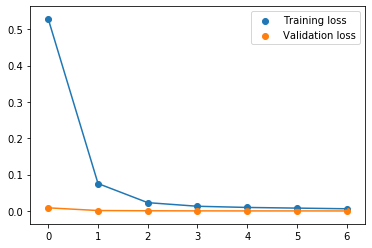

In [12]:
plt.plot(range(current_epcoh), training_vis)
plt.scatter(range(current_epcoh), training_vis, label="Training loss")
plt.scatter(range(current_epcoh), valid_vis, label="Validation loss")
plt.plot(range(current_epcoh), valid_vis)
plt.legend(loc='best')
plt.savefig('SRNet_line.svg')

In [10]:
np.savetxt('SRNet.txt', np.array([training_vis, valid_vis]))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
    
plt.savefig('SRNet_mis.pdf')